In [37]:
# Import standard packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.utils import resample
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report, f1_score, plot_confusion_matrix, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk import pos_tag, FreqDist

from wordcloud import WordCloud

import pickle

pd.options.display.float_format = '{:.3f}'.format
pd.options.display.max_columns = 50
pd.options.display.max_colwidth = 300 # max width of a column

# set random seed to ensure reproducible results
np.random.seed(42)

%matplotlib inline

## Prepare data for modeling

In [2]:
train_df = pd.read_csv('../data/train_df.csv')
train_df.head()

,id,comment_text,target
0,6130267,"I don't think I would be acting like a tough guy in front of my kid with a bat if the other guy had a gun.doesn't seem like much of a fight to me,but then most people don't bring bats to gun fights",1
1,6120855,"The Left will always defends scum like this, as long as their politics are ""correct"". \n\nYet, Democrats and the Left are the ones that claim to want to defend women's rights ... the truth tells a far different story.",1
2,6233267,"I think they will be fighting Hawaiian, Alaska/Virgin America, Delta, United , American Airlines for gate space during peak times at HNL. They all use or will be using medium size aircraft and fight with Wide bodies during this period. State is retrofitting the diamond head concourse for Island...",1
3,452907,"Bad: As pepper spray does not threaten serious bodily harm, nor a reasonable possibility of death, you would probably be prosecuted for use of unjustifiable deadly force. And I was relieved to see you describe yourself as an ""ex-cop"". I would be fearful of having to deal with you if you were ...",1
4,5494517,The fascist movements that threaten us is these twisted ugly leftist hate groups trying to destroy democracy and freedom of religion and freedom of speech disguised as liberalism?.\nYou accept no other opinion but your own.\nYou would destroy freedom instead of admitting you are wrong.\nWe are t...,1


In [3]:
train_df.isna().sum()

id              0
comment_text    0
target          0
dtype: int64

In [4]:
train_df['target'].value_counts()

1    338409
0    338409
Name: target, dtype: int64

In [5]:
# start with small subset of sample to test preprocessing steps
minority_df = train_df[train_df['target']==1]
majority_df = train_df[train_df['target']==0]

majority_small_df = resample(majority_df,
                             replace=False,
                             n_samples=10000,
                             random_state=42)

minority_small_df = resample(minority_df,
                             replace=False,
                             n_samples=10000,
                             random_state=42)

train_df = pd.concat([majority_small_df, minority_small_df])
train_df['target'].value_counts()

0    10000
1    10000
Name: target, dtype: int64

### Complete row-wise data cleaning and transformations

#### Set up functions for preprocessing

In [6]:
def get_wordnet_pos(treebank_tag):
    '''
    Translate nltk POS to wordnet tags
    '''
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [7]:
# Added 'us' to stopwords, because the lemmatizer reduces it to 'u'
sw = stopwords.words('english') + ['us']

def word_processor(comment, stopword_list=sw):
    # tokenize (simultaneously removes punctuation)
    tokenizer = RegexpTokenizer(pattern="([a-zA-Z]+(?:'[a-z]+)?)")
    words = tokenizer.tokenize(comment)

    # lowercase and remove stopwords
    words = [word.lower() for word in words if word.lower() not in stopword_list]
    
    # lemmatize (accounting for part of speech)
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word[0], get_wordnet_pos(word[1])) 
             for word in pos_tag(words)]

    return ' '.join(words)

In [8]:
%%time
train_df['proc_text'] = train_df['comment_text'].map(word_processor)

CPU times: user 31.7 s, sys: 403 ms, total: 32.1 s
Wall time: 32.3 s


In [9]:
train_df.head()

,id,comment_text,target,proc_text
612832,272570,"My Liberal Democrat friends always say they have more intelligence than the average Republican and can govern better. Well here is your chance. It is easy to make money in a bull market, show us how smart you are in a bear one. Show us how the liberal, progressive mind can improve Anchorage u...",0,liberal democrat friend always say intelligence average republican govern well well chance easy make money bull market show smart bear one show liberal progressive mind improve anchorage use dime tax
645974,5794439,Thug Gardens would be a better name these days. Ironically it is Elitche's extremely affordable season passes that make it a magnet for teenage thieves - and their victims. I find it hard to believe the park does not have video cameras which would catch most thefts. I also find it hard to believ...,0,thug garden would better name day ironically elitche's extremely affordable season pass make magnet teenage thief victim find hard believe park video camera would catch theft also find hard believe park security would able apprehend thief guess figure lose backpack punishment pay locker fee
601073,636665,Good Luck with Trans Mountain. Somehow I don't see 400 Super Tankers a year traveling under the Lions Gate and Second Narrow bridges anytime soon. In other news more Tesla Super charging stations were just installed in Alberta and BC. There's progress.,0,good luck trans mountain somehow see super tanker year travel lion gate second narrow bridge anytime soon news tesla super charge station instal alberta bc there's progress
669327,1049406,Not again. Obviously doesn't have the body for this sport. Time to look for another occupation.,0,obviously body sport time look another occupation
549234,461725,Some of those are pretty long-winded questions for a televised debate. Can you sum them up into two sentences each? Otherwise they just come across as editorializing.,0,pretty long winded question televise debate sum two sentence otherwise come across editorialize


## Set up train-test split and pipelines

In [10]:
y = train_df['target']
X = train_df['proc_text']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)#, test_size=100000)

In [11]:
X_train.info()

<class 'pandas.core.series.Series'>
Int64Index: 15000 entries, 557679 to 505090
Series name: proc_text
Non-Null Count  Dtype 
--------------  ----- 
15000 non-null  object
dtypes: object(1)
memory usage: 234.4+ KB


### Preprocessing pipeline

Need to set up pipeline to perform preprocessing steps to each split of the data

In [12]:
subpipe_text = Pipeline(steps=[
    ('cv', CountVectorizer())
])

In [13]:
# cv2 = CountVectorizer()
# cv2.fit_transform(X_train['proc_text'])

#### Verify that ColumnTransformer works
- Ensure that there are no NaN values introduced
- Check min and max values (using describe)

In [15]:
tmp = subpipe_text.fit_transform(X_train)

In [16]:
tmp

<15000x26332 sparse matrix of type '<class 'numpy.int64'>'
	with 355450 stored elements in Compressed Sparse Row format>

In [17]:
tmp_df = pd.DataFrame(data=tmp.toarray(), columns = subpipe_text.named_steps['cv'].get_feature_names_out())

In [18]:
tmp_df.shape

(15000, 26332)

In [19]:
print(f"Number of nulls: {tmp_df.isna().sum().sum()}")
#display(tmp_df.describe())

Number of nulls: 0


In [20]:
# Specify scoring method that will be used to evaluate all models
scoring="f1"

In [21]:
### Using this class (From Flatiron School Lecture 51) to conduct cross-validation, store, and display results

class ModelWithCV():
    '''Structure to save the model and more easily see its crossvalidation'''
    
    def __init__(self, model, model_name, X, y, cv_now=True, scoring="accuracy"):
        self.model = model
        self.name = model_name
        self.X = X
        self.y = y
        # For CV results
        self.cv_results = None
        self.cv_mean = None
        self.cv_median = None
        self.cv_std = None
        #
        if cv_now:
            self.cross_validate()
        
    def cross_validate(self, X=None, y=None, kfolds=10):
        '''
        Perform cross-validation and return results.
        
        Args: 
          X:
            Optional; Training data to perform CV on. Otherwise use X from object
          y:
            Optional; Training data to perform CV on. Otherwise use y from object
          kfolds:
            Optional; Number of folds for CV (default is 10)  
        '''
        
        cv_X = X if X else self.X
        cv_y = y if y else self.y

        self.cv_results = cross_val_score(self.model, cv_X, cv_y, cv=kfolds, scoring=scoring)
        self.cv_mean = np.mean(self.cv_results)
        self.cv_median = np.median(self.cv_results)
        self.cv_std = np.std(self.cv_results)

        
    def print_cv_summary(self):
        cv_summary = (
        f'''CV Results for `{self.name}` model:
            {self.cv_mean:.5f} ± {self.cv_std:.5f} {scoring}
        ''')
        print(cv_summary)

        
    def plot_cv(self, ax):
        '''
        Plot the cross-validation values using the array of results and given 
        Axis for plotting.
        '''
        ax.set_title(f'CV Results for `{self.name}` Model')
        # Thinner violinplot with higher bw
        sns.violinplot(y=self.cv_results, ax=ax, bw=.4)
        sns.swarmplot(
                y=self.cv_results,
                color='orange',
                size=10,
                alpha= 0.8,
                ax=ax
        )

        return ax

In [23]:
dummy_model_pipe = Pipeline(steps=[
    ('subpipe_text',subpipe_text),
    ('dum_class', DummyClassifier(strategy='most_frequent'))
])
dummy_cv = ModelWithCV(dummy_model_pipe, model_name='dummy_model_pipe', X=X_train, y=y_train, scoring=scoring)

CV Results for `dummy_model_pipe` model:
            0.00000 ± 0.00000 f1
        


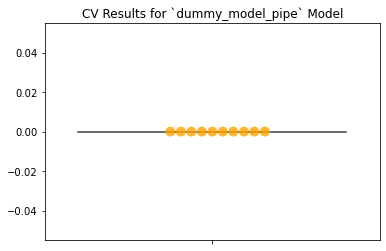

In [24]:
dummy_cv.print_cv_summary()
fig, ax = plt.subplots()

dummy_cv.plot_cv(ax=ax);

              precision    recall  f1-score   support

           0       0.50      1.00      0.67      7500
           1       0.00      0.00      0.00      7500

    accuracy                           0.50     15000
   macro avg       0.25      0.50      0.33     15000
weighted avg       0.25      0.50      0.33     15000



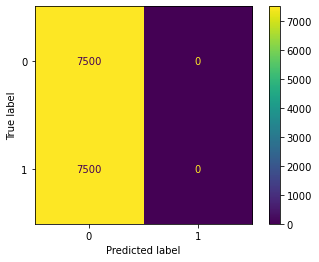

In [42]:
# getting predictions
dummy_model_pipe.fit(X=X_train, y=y_train)
y_pred = dummy_model_pipe.predict(X_train)

# print the classification report to see model metrics
print(classification_report(y_train, y_pred, zero_division=0))

labels=dummy_model_pipe.classes_
cm = confusion_matrix(y_train, y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=labels)
disp.plot();

In [33]:
logreg_model_pipe = Pipeline(steps=[
    ('subpipe_text',subpipe_text),
    ('logreg', LogisticRegression(max_iter=10000))
])
logreg_defaults_cv = ModelWithCV(logreg_model_pipe, model_name='logreg_defaults_model_pipe', 
                                 X=X_train, y=y_train, scoring=scoring)

CV Results for `logreg_defaults_model_pipe` model:
            0.72587 ± 0.00928 f1
        


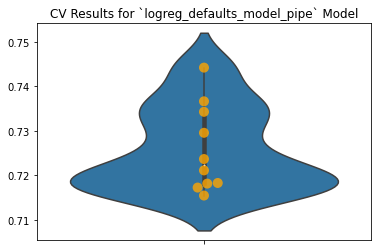

In [34]:
logreg_defaults_cv.print_cv_summary()
fig, ax = plt.subplots()

logreg_defaults_cv.plot_cv(ax=ax);

              precision    recall  f1-score   support

           0       0.94      0.97      0.95      7500
           1       0.97      0.93      0.95      7500

    accuracy                           0.95     15000
   macro avg       0.95      0.95      0.95     15000
weighted avg       0.95      0.95      0.95     15000



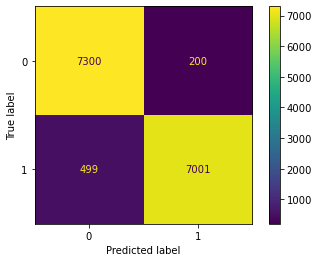

In [43]:
logreg_model_pipe.fit(X_train, y_train)
y_pred = logreg_model_pipe.predict(X_train)

# print the classification report to see model metrics
print(classification_report(y_train, y_pred, zero_division=0))

labels=logreg_model_pipe.classes_
cm = confusion_matrix(y_train, y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=labels)
disp.plot();

In [44]:
mnb_model_pipe = Pipeline(steps=[
    ('subpipe_text',subpipe_text),
    ('mnb', MultinomialNB())
])
mnb_cv = ModelWithCV(mnb_model_pipe, model_name='mnb_model_pipe', 
                                 X=X_train, y=y_train, scoring=scoring)

CV Results for `mnb_model_pipe` model:
            0.72677 ± 0.00936 f1
        


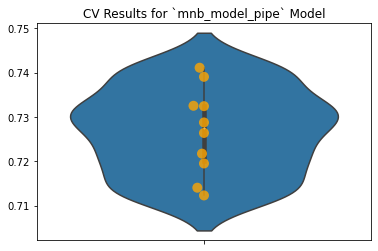

In [45]:
mnb_cv.print_cv_summary()
fig, ax = plt.subplots()

mnb_cv.plot_cv(ax=ax);

              precision    recall  f1-score   support

           0       0.89      0.79      0.84      7500
           1       0.81      0.90      0.85      7500

    accuracy                           0.85     15000
   macro avg       0.85      0.85      0.84     15000
weighted avg       0.85      0.85      0.84     15000



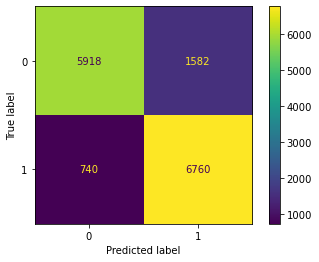

In [46]:
mnb_model_pipe.fit(X_train, y_train)
y_pred = mnb_model_pipe.predict(X_train)

# print the classification report to see model metrics
print(classification_report(y_train, y_pred, zero_division=0))

labels=mnb_model_pipe.classes_
cm = confusion_matrix(y_train, y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=labels)
disp.plot();